# Archetype Crosstalk Network

Adapted from: Adler, M. et al. Emergence of division of labor in tissues through cell interactions and spatial cues. Cell Reports 42, 112412 (2023).

## Packages

In [1]:
import sys
!{sys.executable} -m pip install --quiet decoupler liana requests ipywidgets pybiomart networkx

In [2]:
import os
from pathlib import Path
import requests

import scanpy as sc
import pandas as pd
import numpy as np
import liana as li
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pybiomart import Dataset
from sklearn.mixture import GaussianMixture

import partipy as pt

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Data

In [3]:
data_dir = Path(".") / "data"
data_dir.mkdir(exist_ok=True)

# File URL to download
url = "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE149nnn/GSE149859/suppl/GSE149859%5Fcolon%5Fprocessed%5Fcounts.txt.gz"
filename = data_dir / os.path.basename(url)

# Download file if it does not already exist
if not filename.exists():
    response = requests.get(url, stream=True)
    response.raise_for_status()
    
    with open(filename, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    
    print(f"Downloaded: {filename}")
else:
    print(f"File already exists, skipping: {filename}")

File already exists, skipping: data/GSE149859%5Fcolon%5Fprocessed%5Fcounts.txt.gz


Some data wrangling...

In [4]:
# translate to gene symbols
dataset = Dataset(name="mmusculus_gene_ensembl", host="http://www.ensembl.org")
df = dataset.query(attributes=["ensembl_gene_id", "external_gene_name"])
id_to_symbol = dict(zip(df["Gene stable ID"], df["Gene name"]))

# prepare the counts
count_df = pd.read_csv(data_dir / os.path.basename(url), sep="\t")
count_df = count_df.loc[~count_df.index.str.startswith("ERCC"), :].copy()
count_df = count_df.loc[count_df.values.sum(axis=1) >= 50, :].copy()
count_df["gene_symbol"] = count_df.index.map(id_to_symbol)
count_df = count_df.reset_index(drop=True)
count_df = count_df.groupby("gene_symbol", as_index=True).sum()

adata = sc.AnnData(
    X = count_df.values.T.astype(np.float32),
    obs = pd.DataFrame(index=count_df.columns), 
    var = pd.DataFrame(index=count_df.index)
)
adata

AnnData object with n_obs × n_vars = 1646 × 20196

Subset to fibroblast, and pre-process the single-cell RNA-seq data using scanpy.

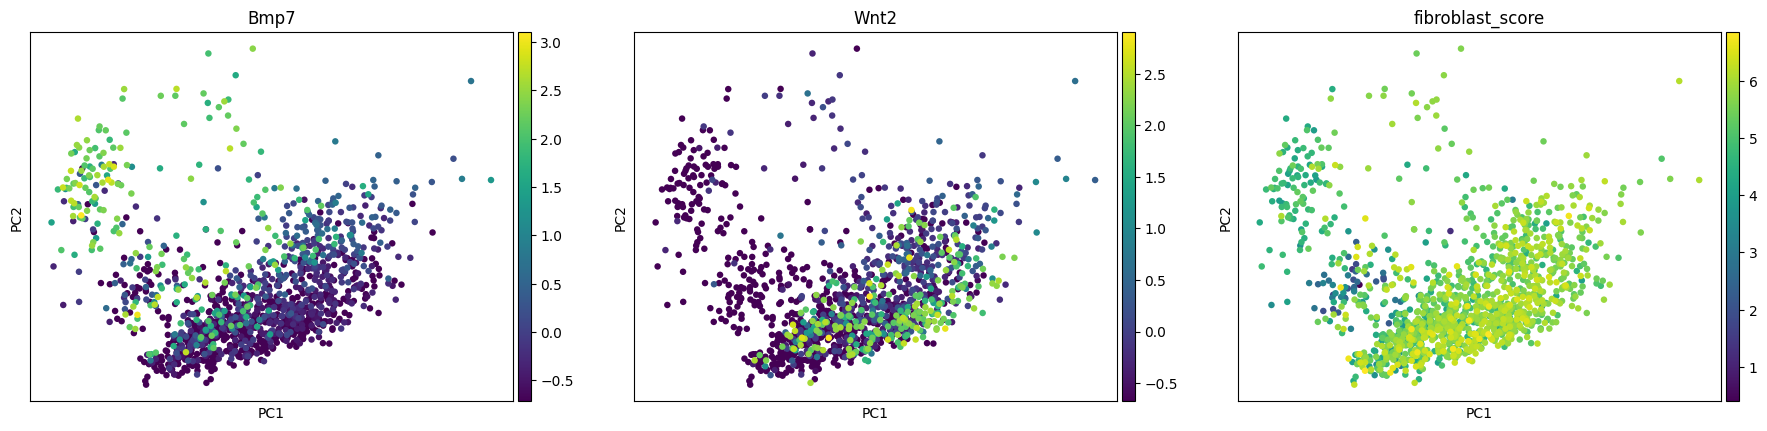

In [5]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata, mask_var="highly_variable", n_comps=20)
adata.obs["fibroblast_score"] = adata[:, ["Col1a1", "Pdgfra", "Lum"]].X.mean(axis=1)
gmm = GaussianMixture(n_components=2, covariance_type="full")
adata.obs["cluster"] = gmm.fit_predict(adata.obsm["X_pca"])
fibro_cluster = int(
    adata.obs.groupby("cluster", as_index=False)["fibroblast_score"]
    .mean()
    .nlargest(1, "fibroblast_score")["cluster"]
    .iat[0]  # More efficient than `.to_list()[0]`
)
adata = adata[adata.obs["cluster"]==fibro_cluster, :].copy()
sc.pp.highly_variable_genes(adata)
sc.pp.pca(adata, mask_var="highly_variable", n_comps=50)
adata.layers["z_scaled"]= sc.pp.scale(adata.X, max_value=10) # save this for later
sc.pl.pca_scatter(adata, color=["Bmp7", "Wnt2", "fibroblast_score"])

Based on the PCA scree plot, we will be using 8 PC dimensions to fit the archetypes.

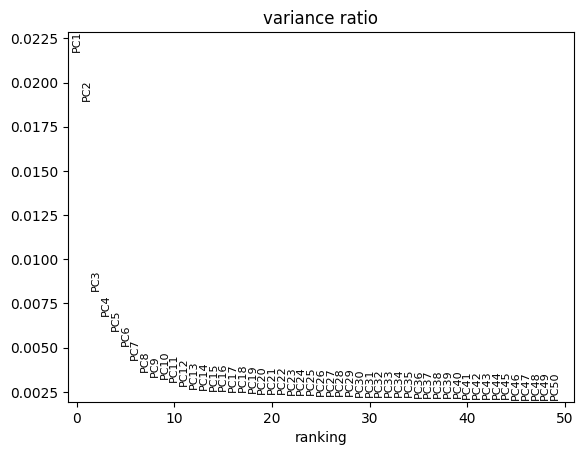

In [6]:
sc.pl.pca_variance_ratio(adata, n_pcs=50)
pt.set_dimension_aa(adata=adata, n_pcs=8)

In [7]:
#var_explained_aa(adata=adata, min_a=2, max_a=10)
#plot_var_explained_aa(adata)

Here, we will use 5 archetypes. When fitting 4 archetypes we have observed that running archetypal analysis on bootstrapped data shows that one archetype is quite unstable, whereas using 5 worked much better.

Algorithm converged after 68 iterations.


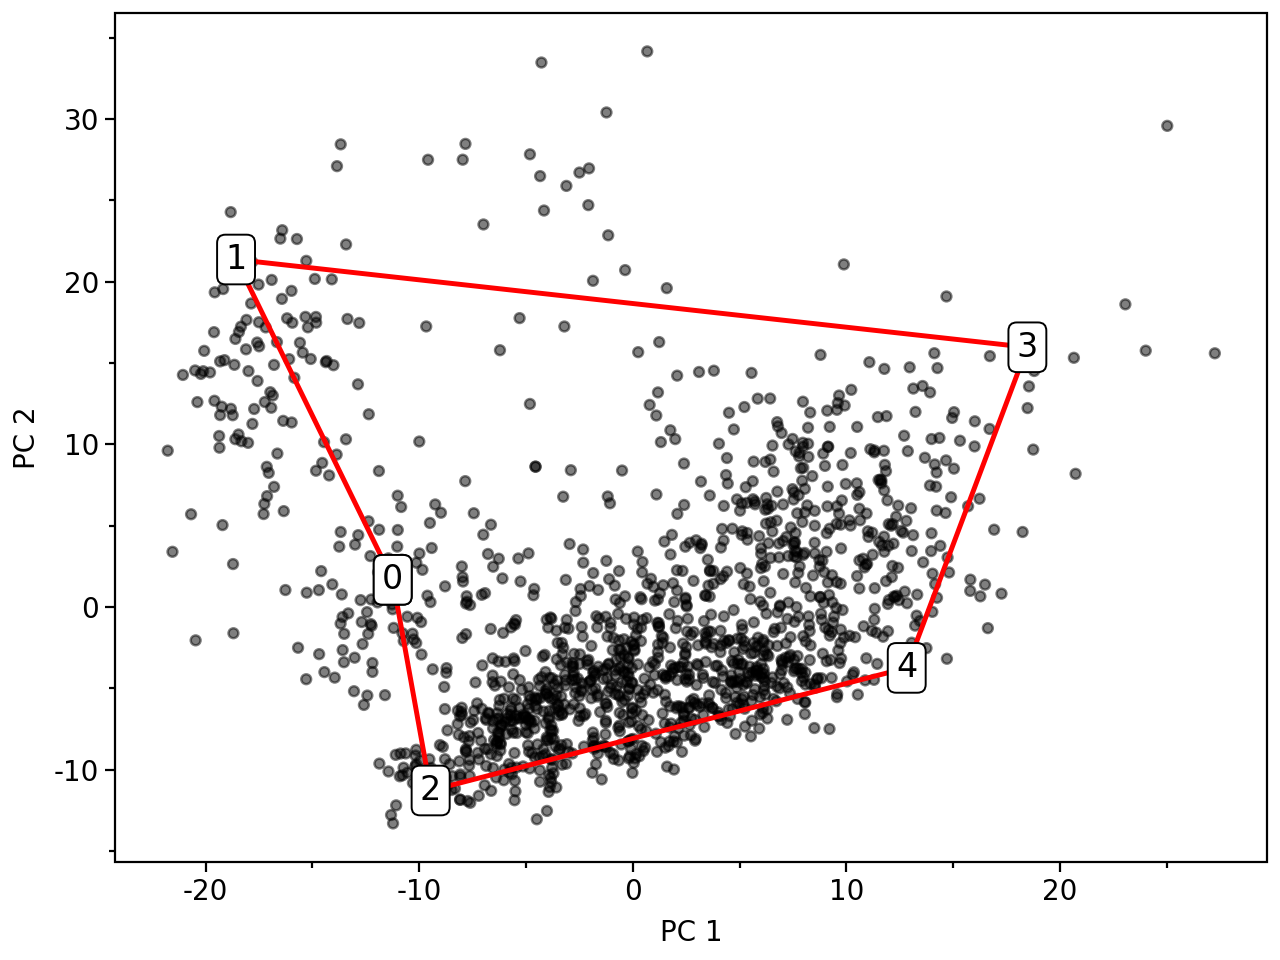

In [8]:
pt.compute_archetypes(adata, n_archetypes=5, init="furthest_sum", max_iter=100, verbose=True)
pt.plot_archetypes_2D(adata=adata)

Determine which genes are characteristic for each archetype

Applied length scale is 12.98820926112525.


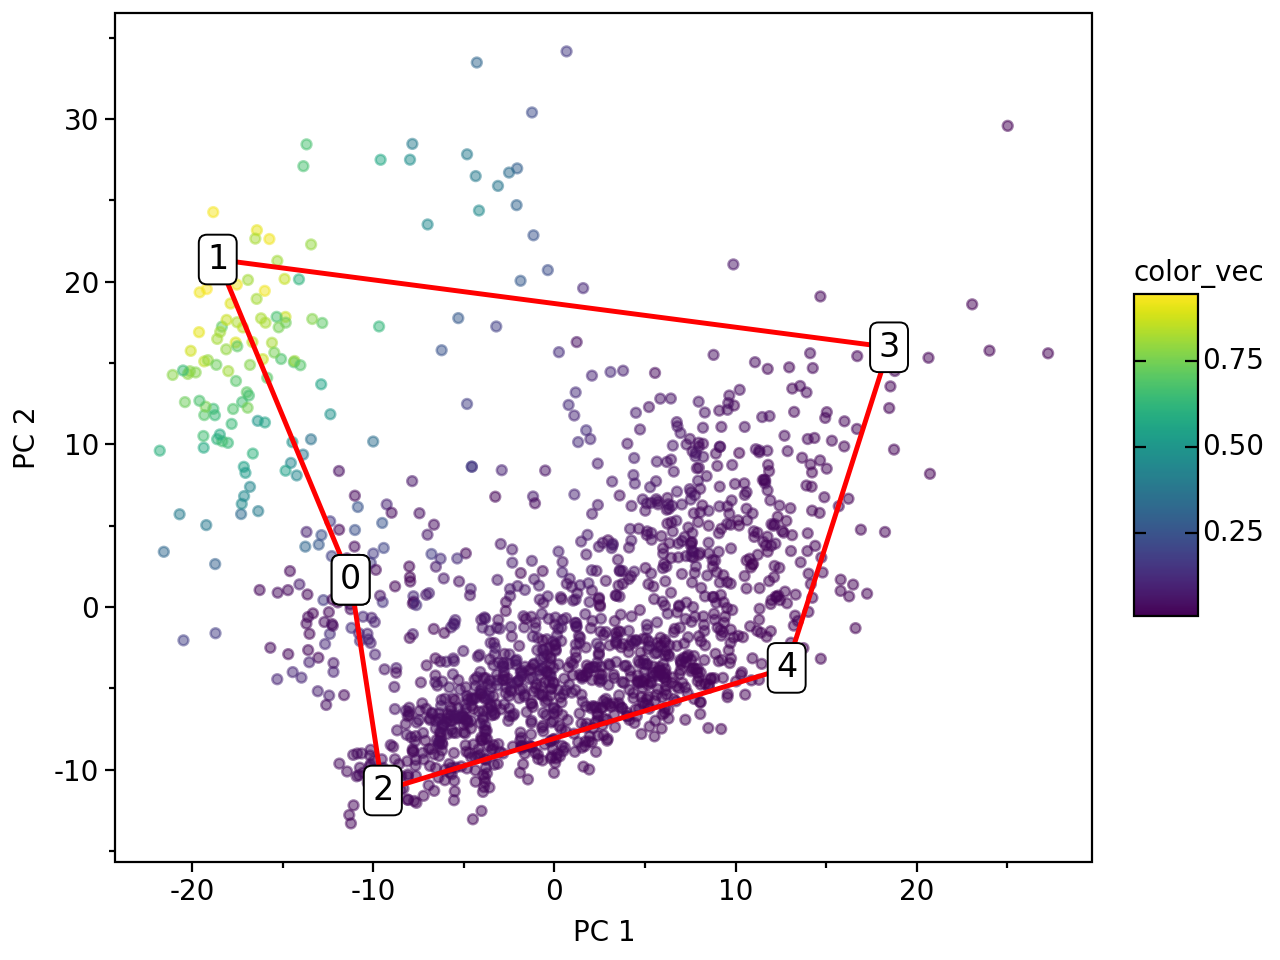

In [9]:
pt.compute_archetype_weights(X=adata, mode="automatic")
pseudobulk = pt.compute_archetype_expression(adata=adata, layer="z_scaled")

adata.obs["weights_archetype_1"] = adata.obsm["cell_weights"][:, 1]
pt.plot_archetypes_2D(adata=adata, color="weights_archetype_1")

In [10]:
def get_specific_genes_per_archetype(pseudobulk, 
                                     min_score=-np.inf,
                                     max_score=np.inf):
    expr_df = pseudobulk.T
    archetype_dict = {}
    for col in expr_df.columns:
        other_cols = [c for c in expr_df.columns if c != col]
        archetype_dict[col] =  (pd.DataFrame(
            {"z_score": expr_df[col].to_numpy(),
             "max_z_score_others": (expr_df[other_cols].values).max(axis=1),
             "specificity_score": (expr_df[[col]].values - expr_df[other_cols].values).min(axis=1),
             "gene": expr_df.index.to_numpy()}
        )).sort_values("specificity_score", ascending=False)
        # filtering
        archetype_dict[col] = archetype_dict[col].loc[(archetype_dict[col]["specificity_score"] >= min_score) & 
                                                      (archetype_dict[col]["specificity_score"] <= max_score), :].copy()
    return archetype_dict

specific_genes_per_archetype = get_specific_genes_per_archetype(pseudobulk=pseudobulk, min_score=0.05)

[(arch_id, len(arch_genes)) for arch_id, arch_genes in specific_genes_per_archetype.items()]

[(0, 1466), (1, 2085), (2, 71), (3, 5321), (4, 1205)]

Based on the genes we infer the functions of each archetype

In [11]:
for i in range(len(specific_genes_per_archetype)):
    print(i, specific_genes_per_archetype[i].head(25)["gene"].to_list())

0 ['Lmod1', 'Cnn1', 'Actg2', 'Pdgfc', 'Cdh6', 'Itga8', 'Myocd', 'Asb2', 'Tagln', 'Kcnmb1', 'Tnfrsf19', 'Acta1', 'Myh11', 'Trpc6', 'Tspan2', 'Slc2a4', 'Pcp4l1', 'Hspb7', 'Pde6h', 'Gm16000', 'Ctxn1', 'Acta2', 'Ptk2b', 'Hhip', 'E030013I19Rik']
1 ['Cd38', 'Nrg1', '1700071M16Rik', 'Lef1', 'Lef1os1', 'Cdhr17', 'Rab3b', 'Trpa1', 'Pla2g7', 'Lpar3', 'Lama5', 'Ano2', 'Ptprr', 'Cd300e', 'Glp2r', 'C5ar1', 'Sema4d', 'Abcc4', 'Tbx3', 'Cox4i2', 'Tspan13', 'Ano1', 'Procr', 'Eva1a', 'Insc']
2 ['Bcl6', 'Hpse2', 'Ugcg', 'Serping1', 'Ccbe1', 'Dnm3os', 'Gm16089', 'Edil3', 'Gm8369', 'Ms4a4b', 'Ces2b', 'Rax', 'D630033O11Rik', 'Cxcl12', 'Gm16263', 'Hoxc9', 'Gm43025', 'Gsdmc4', 'Tpt1-ps5', 'Iglv1', 'Zfp808', 'C1rb', 'Chdh', 'Gm10212', 'Dlx6']
3 ['Sox18', 'Mmrn2', 'Plvap', 'Ushbp1', 'Tie1', 'Robo4', 'Emcn', 'Flt1', 'Kdr', 'Egfl7', 'Fabp4', 'Dll4', 'Podxl', 'Cd300lg', 'Adgrg1', 'Adgrl4', 'Cd24a', 'Depp1', 'Sox17', 'Gimap6', 'Car4', 'Gdf10', 'Exoc3l2', 'Bcam', 'Fam110d']
4 ['Efhd1os', '1700019D03Rik', 'Efhd1', 'S

In [12]:
archetype_functions = {
    0: "ECM-remodeling fibroblasts",
    1: "Vascular-associated fibroblasts",
    2: "Neuronal/epithelial-interacting fibroblasts",
    3: "Myofibroblasts",
    4: "Immune-modulatory fibroblasts"
}

Finally we use [LIANA+](https://liana-py.readthedocs.io/en/latest/) to infer ligand and receptor are enriched between archetypes. But first we need to translate the human ligand-receptor database to mouse gene symbols.

In [13]:
human_resource = li.rs.select_resource('consensus')

# let's say we are interested in zebrafish homologs of human genes
map_df = li.rs.get_hcop_orthologs(url='https://ftp.ebi.ac.uk/pub/databases/genenames/hcop/human_mouse_hcop_fifteen_column.txt.gz',
                                   columns=['human_symbol', 'mouse_symbol'],
                                   # NOTE: HCOP integrates multiple resource, so we can filter out mappings in at least 3 of them for confidence
                                   min_evidence=3
                                   )
# rename the columns to source and target, respectively for the original organism and the target organism
map_df = map_df.rename(columns={'human_symbol':'source', 'mouse_symbol':'target'})

mouse_resource = li.rs.translate_resource(human_resource,
                                          map_df=map_df,
                                          columns=['ligand', 'receptor'],
                                          replace=True,
                                          # NOTE that we need to define the threshold of redundancies for the mapping
                                          # # in this case, we would keep mappings as long as they don't map to more than 2 mouse genes
                                          # one_to_many=3
                                          )
mouse_resource

/Users/pschafer/miniforge3/envs/partipy/lib/python3.11/site-packages/liana/resource/_orthology.py:199: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.


,ligand,receptor
0,Lgals9,Ptprc
1,Lgals9,Met
2,Lgals9,Cd44
3,Lgals9,Lrp1
4,Lgals9,Cd47
...,...,...
4619,Bmp2,Actr2
4620,Bmp15,Actr2
4621,Csf1,Csf3r
4622,Il36g,Ifnar1


In [14]:
def get_archetype_crosstalk(archetype_genes: dict, lr_resource):
    interactions_dict = {}
    for sender_arch in archetype_genes.keys():
        interactions_dict[sender_arch] = {}
        for receiver_arch in archetype_genes.keys():
            sender_genes = archetype_genes[sender_arch]
            receiver_genes = archetype_genes[receiver_arch]

            lr_df = lr_resource.copy()
            lr_df = lr_df.loc[(lr_df["ligand"].isin(sender_genes["gene"])) & (lr_df["receptor"].isin(receiver_genes["gene"])), :].copy()
            lr_df = lr_df.join((sender_genes
                                .rename(columns={"z_score": "ligand_z_score", "specificity_score": "ligand_specificity_score"})
                                .loc[:, ["gene", "ligand_z_score", "ligand_specificity_score"]]
                                .set_index("gene")),
                                how="left", on="ligand")
            lr_df = lr_df.join((receiver_genes
                                .rename(columns={"z_score": "receptor_z_score", "specificity_score": "receptor_specificity_score"})
                                .loc[:, ["gene", "receptor_z_score", "receptor_specificity_score"]]
                                .set_index("gene")),
                                how="left", on="receptor")
            interactions_dict[sender_arch][receiver_arch] = lr_df
    return interactions_dict

archetype_crosstalk = get_archetype_crosstalk(archetype_genes=specific_genes_per_archetype, 
                                              lr_resource=mouse_resource)

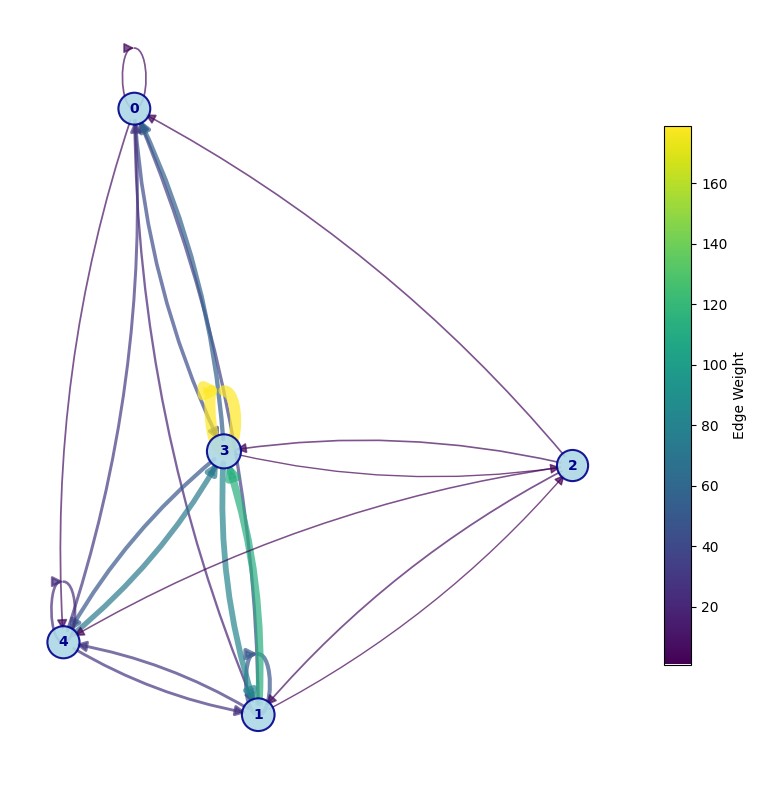

In [15]:
def plot_weighted_network(archetype_crosstalk_dict, threshold=0.0, layout='circular', seed=42, figsize=(8, 8), plot_edge_labels=False):
    """
    Create a visualization with angle-based edge label placement.
    """
    # create interaction matrix
    interactions_mtx = np.zeros((len(specific_genes_per_archetype), len(specific_genes_per_archetype)))
    for sender_arch in specific_genes_per_archetype.keys():
        for receiver_arch in specific_genes_per_archetype.keys():
            interactions_mtx[sender_arch, receiver_arch] = len(archetype_crosstalk_dict[sender_arch][receiver_arch])

    G = nx.DiGraph()
    num_nodes = interactions_mtx.shape[0]
    
    # Build graph
    for i in range(num_nodes):
        for j in range(num_nodes):
            if (weight := interactions_mtx[i, j]) > threshold:
                G.add_edge(i, j, weight=weight)

    # Layout
    layout_fns = {
        'circular': nx.circular_layout,
        'spring': lambda G: nx.spring_layout(G, k=1.5, iterations=100, seed=seed),
        'shell': nx.shell_layout
    }
    pos = layout_fns.get(layout, nx.circular_layout)(G)

    # Setup plot
    fig, ax = plt.subplots(figsize=figsize, facecolor='white')
    
    # Draw nodes
    node_degree = dict(G.degree(weight='weight'))
    max_degree = max(node_degree.values()) if node_degree else 1
    node_sizes = [500 + 100 * (node_degree[n]/max_degree) for n in G.nodes()]
    
    nx.draw_networkx_nodes(
        G, 
        pos, 
        node_color='lightblue', 
        node_size=node_sizes,
        edgecolors='darkblue', 
        linewidths=1.5, 
        alpha=0.9, 
        ax=ax
    )

    # Draw edges
    edge_weights = [G[u][v]['weight'] for u, v in G.edges()]
    cmap = plt.colormaps['viridis']
    norm = mcolors.Normalize(vmin=min(edge_weights), vmax=max(edge_weights)) if edge_weights else None

    # Calculate edge widths based on weights (scaled)
    edge_widths = []
    if edge_weights:
        min_weight = min(edge_weights)
        max_weight = max(edge_weights)
        if max_weight == min_weight:
            edge_widths = [2.0] * len(edge_weights)  # Default width
        else:
            edge_widths = [1.0 + 7.0 * (w - min_weight) / 
                          (max_weight - min_weight) 
                          for w in edge_weights]

    nx.draw_networkx_edges(
        G, pos,
        edge_color=edge_weights, 
        edge_cmap=cmap,
        alpha=0.7, 
        width=edge_widths, 
        arrows=True,
        arrowsize=15,
        connectionstyle="arc3,rad=0.1", 
        ax=ax
    )

    # Draw node labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight='bold', font_color='darkblue', ax=ax)

    # ANGLE-BASED EDGE LABELS
    if (G.number_of_edges() < 50) and plot_edge_labels:
        edge_labels = {(i, j): f"{interactions_mtx[i, j]:.2f}" 
                      for i, j in G.edges()}
        
        def get_label_pos_rotation(u, v, offset=0.08):
            """Calculate label position and rotation angle"""
            x1, y1 = pos[v]
            x2, y2 = pos[u]
            dx, dy = x2 - x1, y2 - y1
            
            # Midpoint coordinates
            mid_x = (x1 + x2) / 2
            mid_y = (y1 + y2) / 2
            
            # Perpendicular offset direction
            angle = np.arctan2(dy, dx)
            perp_angle = angle + np.pi/2  # 90 degree offset
            
            # Calculate offset coordinates
            label_x = mid_x + offset * np.cos(perp_angle)
            label_y = mid_y + offset * np.sin(perp_angle)
            
            # Convert angle to degrees for matplotlib
            rotation = np.degrees(angle)
            
            return (label_x, label_y), rotation
        
        for (u, v), label in edge_labels.items():
            label_pos, rotation = get_label_pos_rotation(u, v)
            
            # Draw label with alignment following edge angle
            ax.text(
                label_pos[0], label_pos[1], label,
                rotation=rotation,
                rotation_mode='anchor',
                fontsize=8,
                color='darkred',
                ha='center', va='center',
                bbox=dict(alpha=0.7, facecolor='white', edgecolor='none')
            )

    # Colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    plt.colorbar(sm, ax=ax, label='Edge Weight', shrink=0.7)
    
    ax.axis('off')
    plt.tight_layout()
    plt.show()

# Use the function
plot_weighted_network(archetype_crosstalk_dict=archetype_crosstalk,
                      layout="spring", seed=42)